# Brain Tumor Detection Using a Convolutional Neural Network

## Import  Modules

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [5]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [6]:
# Allow memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data Preparation & Preprocessing

In [7]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

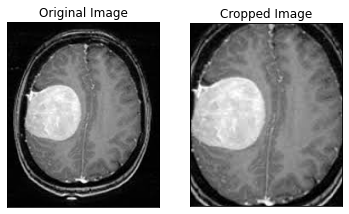

In [8]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

In [9]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [10]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)



### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [11]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [13]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [14]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [15]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

convolutional neural network model:

<img src='convnet_architecture.jpg'>

In [16]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [17]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [18]:
model = build_model(IMG_SHAPE)

In [19]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

Compile the model:

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# checkpoint
ckp3 = ModelCheckpoint("cnn_model.model")

## Train the model

In [36]:
start_time = time.time()

# model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))
model.fit(x=X_train, y=y_train, batch_size=32, epochs=40, validation_data=(X_val, y_val), callbacks=[ckp3])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/40
1445/1445 [==============================] - 26s 18ms/sample - loss: 0.1776 - accuracy: 0.9273 - val_loss: 0.2889 - val_accuracy: 0.8677
Epoch 2/40
1445/1445 [==============================] - 26s 18ms/sample - loss: 0.2035 - accuracy: 0.9163 - val_loss: 0.3051 - val_accuracy: 0.8742
Epoch 3/40
1445/1445 [==============================] - 25s 17ms/sample - loss: 0.1349 - accuracy: 0.9592 - val_loss: 0.3047 - val_accuracy: 0.8710
Epoch 4/40
1445/1445 [==============================] - 25s 17ms/sample - loss: 0.1338 - accuracy: 0.9550 - val_loss: 0.2617 - val_accuracy: 0.8968
Epoch 5/40
1445/1445 [==============================] - 24s 17ms/sample - loss: 0.1321 - accuracy: 0.9550 - val_loss: 0.4479 - val_accuracy: 0.8323
Epoch 6/40
1445/1445 [==============================] - 25s 18ms/sample - loss: 0.1326 - accuracy: 0.9529 - val_loss: 0.3662 - val_accuracy: 0.8613
Epoch 7/40
1445/1445 [==============================] - 25s 17ms/

Epoch 29/40
1445/1445 [==============================] - 24s 17ms/sample - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.3065 - val_accuracy: 0.9000
Epoch 30/40
1445/1445 [==============================] - 25s 17ms/sample - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.3333 - val_accuracy: 0.9065
Epoch 31/40
1445/1445 [==============================] - 26s 18ms/sample - loss: 0.0190 - accuracy: 0.9993 - val_loss: 0.3248 - val_accuracy: 0.9161
Epoch 32/40
1445/1445 [==============================] - 25s 17ms/sample - loss: 0.0178 - accuracy: 0.9986 - val_loss: 0.3047 - val_accuracy: 0.9097
Epoch 33/40
1445/1445 [==============================] - 24s 17ms/sample - loss: 0.0208 - accuracy: 0.9986 - val_loss: 0.4155 - val_accuracy: 0.8839
Epoch 34/40
1445/1445 [==============================] - 26s 18ms/sample - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.3309 - val_accuracy: 0.9129
Epoch 35/40
1445/1445 [==============================] - 24s 17ms/sample - loss: 0.0111 - accuracy: 0.9993

## Plot Loss & Accuracy

In [37]:
history = model.history.history

In [38]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [39]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

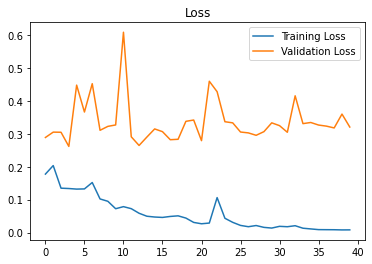

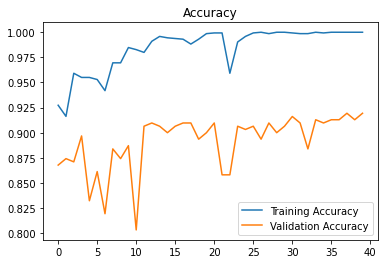

In [40]:
plot_metrics(history) 

# Results

### Load the best model

In [41]:
model = load_model(filepath='cnn_model.model')

In [42]:
model.metrics_names

['loss', 'accuracy']

In [43]:
loss, acc = model.evaluate(x=X_test, y=y_test)

310/310 [==============================] - 7s 21ms/sample - loss: 0.4683 - accuracy: 0.8968


### Accuracy of the best model on the testing data:

In [44]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.4682889461517334
Test Accuracy = 0.896774172782898


### F1 score for the best model on the testing data:

In [46]:
y_test_prob = model.predict(X_test)

In [48]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8967741935483872


f1 score on the validation data:

In [50]:
y_val_prob = model.predict(X_val)

In [51]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9262536873156341


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [52]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [53]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [54]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.31833910034602%, number of pos examples: 756
Percentage of negative examples: 47.68166089965398%, number of neg examples: 689
Validation Data:
Number of examples: 310
Percentage of positive examples: 55.483870967741936%, number of pos examples: 172
Percentage of negative examples: 44.516129032258064%, number of neg examples: 138
Testing Data:
Number of examples: 310
Percentage of positive examples: 50.645161290322584%, number of pos examples: 157
Percentage of negative examples: 49.354838709677416%, number of neg examples: 153


As expectred, the percentage of positive examples are around 50%.

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**89.6%** accuracy on the **test set**.<br>
**0.89** f1 score on the **test set**.<br>